# This file contains an Exploratory Data Analysis

First, the data from brandwatch is validated. Then we explore the different variables and do some time series analysis



In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

In [16]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr

# Amount of comments
expected = [
    13, 45, 31, 8, 4, 34,        # Šeško
    1, 2, 1, 4, 1, 11,           # Openda
    38, 36, 75, 27, 118, 190,    # Cunha
    0, 3, 9, 0, 5, 0,            # Aghehowa
    45, 142, 115, 51, 148, 938   # Thuram
]

actual = [
    23, 24, 19, 11, 8, 57,
    3, 2, 7, 8, 3, 21,
    48, 70, 81, 36, 68, 206,
    4, 10, 6, 3, 10, 4,
    69, 147, 154, 59, 178, 1432
]

spearman_corr, _ = spearmanr(expected, actual)

print(f"Spearman Correlation: {spearman_corr:.2f}")


Spearman Correlation: 0.95


In [28]:
import pandas as pd

filepath = "../dataframes/final_versions/daily_player_dataset.csv"  
df = pd.read_csv(filepath, sep="\t")

numeric_cols = [
    "age", "height", "market_value", "total_mentions", "pos_mentions", "neg_mentions",
    "total_X", "pos_X", "neg_X", "total_news", "pos_news", "neg_news",
    "total_reddit", "pos_reddit", "neg_reddit", "mins_played", "goal_total", "assist",
    "yellow_card", "red_card", "shots_total", "pass_success", "aerial_won", "rating",
    "team_goals", "opponent_goals", "match_points"
]

summary = df[numeric_cols].agg(['max', 'min', 'mean', 'std']).transpose()
summary.columns = ["Max", "Min", "Mean", "Std. Dev."]
print(summary)

summary.to_csv("daily_dataset_summary.csv", sep='\t')

                        Max        Min          Mean     Std. Dev.
age                    40.0      17.00  2.526986e+01  3.673697e+00
height                201.0     170.00  1.839696e+02  6.052891e+00
market_value    193682951.0  210000.00  2.048986e+07  2.245850e+07
total_mentions     195725.0       0.00  4.469314e+02  3.042357e+03
pos_mentions       101869.0       0.00  7.008383e+01  8.345882e+02
neg_mentions        34018.0       0.00  3.431711e+01  3.310258e+02
total_X            192731.0       0.00  3.814227e+02  2.895527e+03
pos_X              100547.0       0.00  6.254194e+01  8.154160e+02
neg_X               32561.0       0.00  2.617162e+01  3.113206e+02
total_news          25218.0       0.00  5.974950e+01  3.040076e+02
pos_news             3500.0       0.00  6.346817e+00  3.941470e+01
neg_news             1631.0       0.00  6.717776e+00  3.404029e+01
total_reddit          614.0       0.00  1.860815e+00  8.688030e+00
pos_reddit             80.0       0.00  2.001418e-01  1.273146

/var/folders/zf/15945wd942l6qm0t9kdbqk5m0000gp/T/ipykernel_3606/3188075491.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


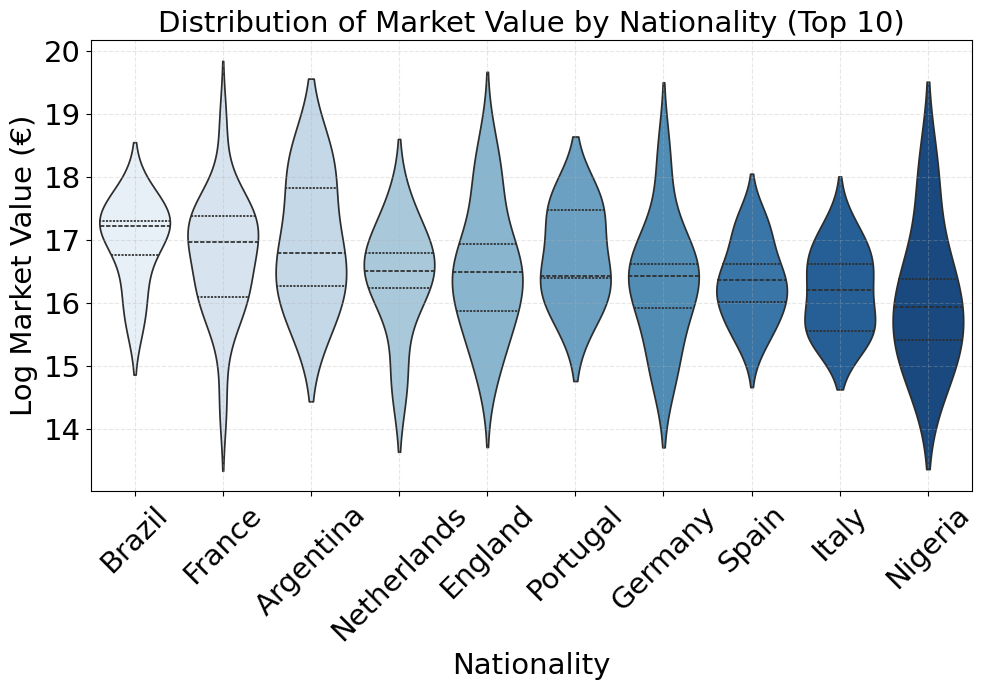

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data 
daily_df = pd.read_csv("../dataframes/final_versions/daily_player_dataset.csv", sep="\t", parse_dates=["date"])
static_df = pd.read_csv("../dataframes/final_versions/static_combined.csv", sep="\t")

# Drop rows with missing market value or nationality
static_df = static_df.dropna(subset=["log_market_value", "nationality"])

# Filter to top 15 most frequent nationalities
top_nationalities = static_df["nationality"].value_counts().nlargest(10).index
filtered_df = static_df[static_df["nationality"].isin(top_nationalities)]

# Sort nationalities by median log market value
sorted_order = (
    filtered_df.groupby("nationality")["log_market_value"]
    .median()
    .sort_values(ascending=False)
    .index
)

# Plot
plt.figure(figsize=(10, 7))
sns.violinplot(
    data=filtered_df,
    x="nationality",
    y="log_market_value",
    palette=sns.color_palette("Blues", n_colors=10),
    order=sorted_order,
    inner="quartile"  # shows quartiles inside violin
)

plt.title("Distribution of Market Value by Nationality (Top 10)", fontsize=21)
plt.xlabel("Nationality", fontsize=21)
plt.ylabel("Log Market Value (€)", fontsize=21)
plt.xticks(rotation=45, fontsize=21)
plt.yticks(fontsize=21)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


/var/folders/zf/15945wd942l6qm0t9kdbqk5m0000gp/T/ipykernel_3606/621179865.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


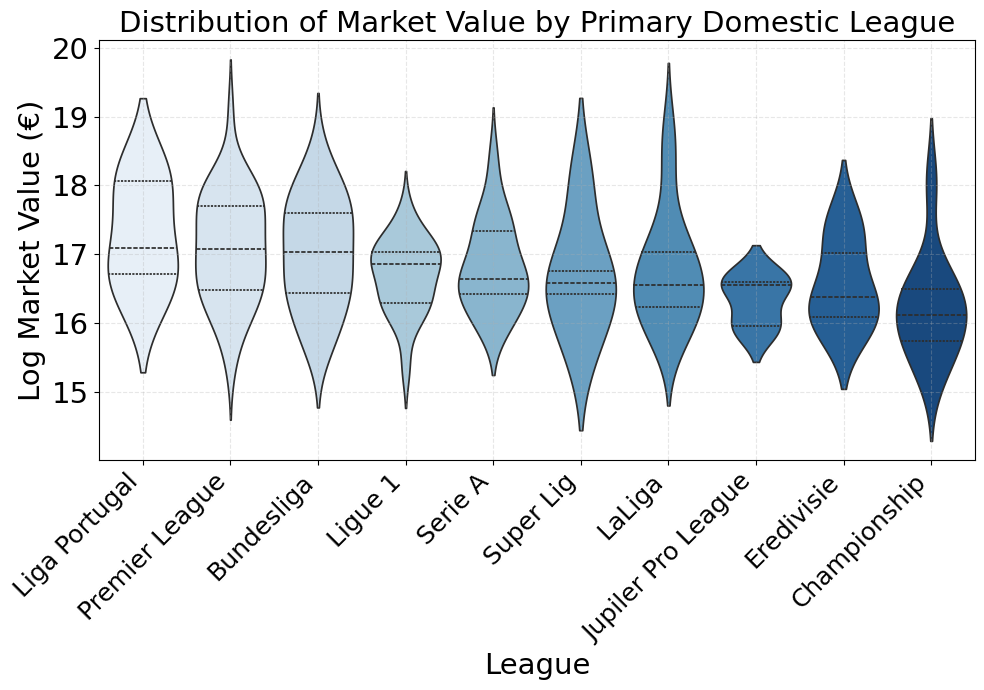

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load datasets
daily_df = pd.read_csv("../dataframes/final_versions/daily_player_dataset.csv", sep="\t", parse_dates=["date"])
static_df = pd.read_csv("../dataframes/final_versions/static_combined.csv", sep="\t")

# Drop rows without league or market value 
daily_df = daily_df.dropna(subset=["league", "market_value"])

# Assign primary league: most frequent league per player 
primary_league_map = (
    daily_df.groupby(["player_id", "league"])
    .size()
    .reset_index(name="count")
    .sort_values(["player_id", "count"], ascending=[True, False])
    .drop_duplicates(subset="player_id")
    .set_index("player_id")["league"]
)

# Get latest market value for each player 
latest_market_values = (
    daily_df.sort_values(["player_id", "date"])
    .groupby("player_id")
    .tail(1)[["player_id", "market_value"]]
)

# Merge static + primary league + market value 
merged_df = static_df[["player_id", "nationality"]].copy()
merged_df["primary_league"] = merged_df["player_id"].map(primary_league_map)
merged_df = pd.merge(merged_df, latest_market_values, on="player_id", how="inner")

# Log-transform market value
merged_df["log_market_value"] = np.log(merged_df["market_value"])
merged_df = merged_df.dropna(subset=["primary_league", "log_market_value"])

# Filter to top 10 most common domestic leagues
top_leagues = merged_df["primary_league"].value_counts().nlargest(10).index
filtered_df = merged_df[merged_df["primary_league"].isin(top_leagues)]

# Order by median market value
league_order = (
    filtered_df.groupby("primary_league")["log_market_value"]
    .median()
    .sort_values(ascending=False)
    .index
)

# Plot
plt.figure(figsize=(10, 7))
palette = sns.color_palette("Blues", n_colors=10)

sns.violinplot(
    data=filtered_df,
    x="primary_league",
    y="log_market_value",
    palette=palette,
    inner="quartile", 
    order=league_order
)

plt.title("Distribution of Market Value by Primary Domestic League", fontsize=21)
plt.xlabel("League", fontsize=21)
plt.ylabel("Log Market Value (€)", fontsize=21)
plt.xticks(rotation=45, ha="right", fontsize=18)
plt.yticks(fontsize=21)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


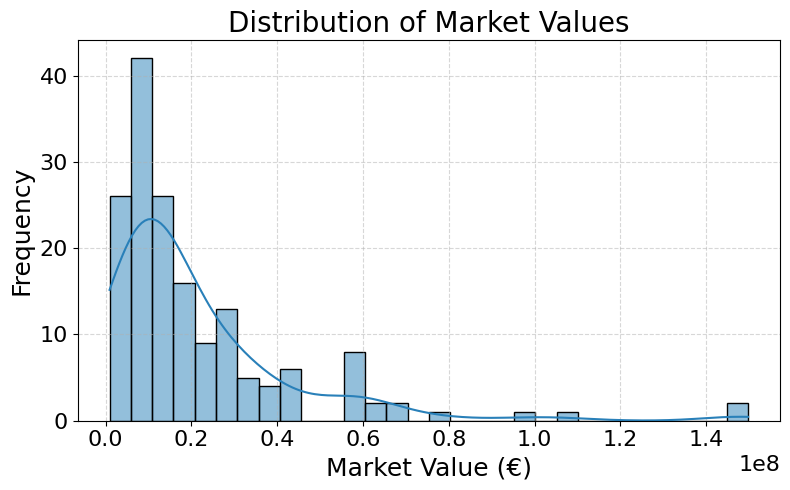

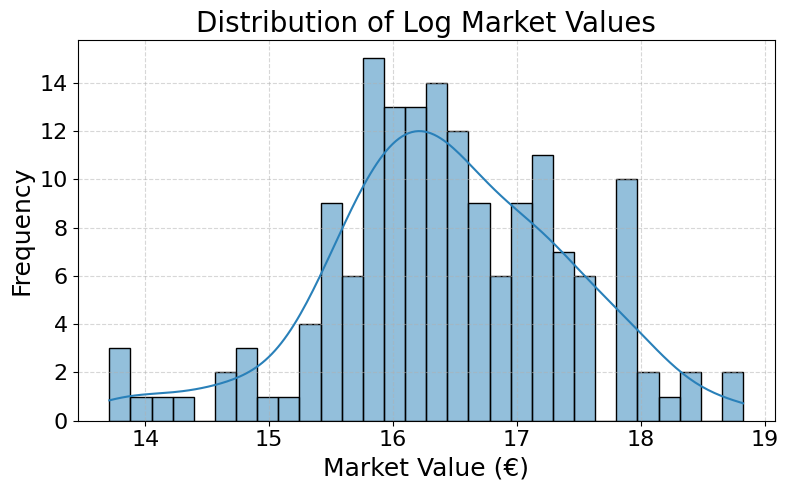

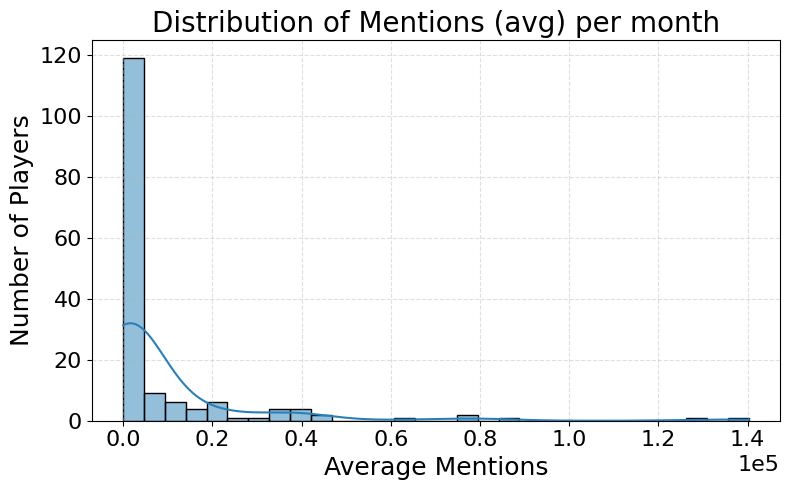

In [15]:
# EDA Notebook: Understanding Player Market Value Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

# Load all dataframes
static_df = pd.read_csv("../dataframes/final_versions/static_combined.csv", sep="\t")
monthly_df = pd.read_csv("../dataframes/final_versions/monthly_final.csv", sep="\t", parse_dates=["month"])
daily_df = pd.read_csv("../dataframes/final_versions/daily_final.csv", sep="\t", parse_dates=["date"])

# Get sets of player IDs
static_ids = set(static_df["player_id"])
monthly_ids = set(monthly_df["player_id"])


# Font sizes
title_fontsize = 20
label_fontsize = 26
tick_fontsize = 18
tick_2 = 16


# 1. Distribution of Market Values
plt.figure(figsize=(8, 5))
sns.histplot(static_df['footballtransfer'], bins=30, kde=True, color="#2980B9")
plt.title("Distribution of Market Values", fontsize=title_fontsize)
plt.tick_params(axis='x', labelsize=tick_2)
plt.tick_params(axis='y', labelsize=tick_2)
plt.xlabel("Market Value (€)", fontsize=tick_fontsize)
plt.ylabel("Frequency", fontsize=tick_fontsize)
plt.grid(True, linestyle="--", alpha=0.5)
plt.gca().xaxis.get_offset_text().set_fontsize(tick_2)  # increase offset text size
plt.tight_layout()
plt.show()

static_df['log_mv'] = np.log(static_df['footballtransfer'])

plt.figure(figsize=(8, 5))
sns.histplot(static_df['log_mv'], bins=30, kde=True, color="#2980B9")
plt.title("Distribution of Log Market Values", fontsize=title_fontsize)
plt.tick_params(axis='x', labelsize=tick_2)
plt.tick_params(axis='y', labelsize=tick_2)
plt.xlabel("Market Value (€)", fontsize=tick_fontsize)
plt.ylabel("Frequency", fontsize=tick_fontsize)
plt.grid(True, linestyle="--", alpha=0.5)
plt.gca().xaxis.get_offset_text().set_fontsize(tick_2)  # increase offset text size
plt.tight_layout()
plt.show()



import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter

# Monthly Mentions Trend
total_mentions_per_player = monthly_df.groupby("player_id")["total_mentions"].mean()

# Remove top 1% for better visualization
threshold = total_mentions_per_player.quantile(0.99)
filtered_mentions = total_mentions_per_player[total_mentions_per_player < threshold]

from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(filtered_mentions, bins=30, kde=True, color="#2980B9", ax=ax)

# Title & labels
ax.set_title("Distribution of Mentions (avg) per month", fontsize=title_fontsize)
ax.set_xlabel("Average Mentions", fontsize=tick_fontsize)
ax.set_ylabel("Number of Players", fontsize=tick_fontsize)
ax.tick_params(axis='x', labelsize=tick_2)
ax.tick_params(axis='y', labelsize=tick_2)
ax.grid(True, linestyle="--", alpha=0.4)

#  Formatter with plain '1e5' instead of ×10⁵
formatter = ScalarFormatter(useMathText=False)
formatter.set_scientific(True)
formatter.set_powerlimits((5, 5))  # force scientific notation for 10⁵
ax.xaxis.set_major_formatter(formatter)

# Optional: adjust offset font size
ax.xaxis.get_offset_text().set_fontsize(tick_2)

plt.tight_layout()
plt.show()



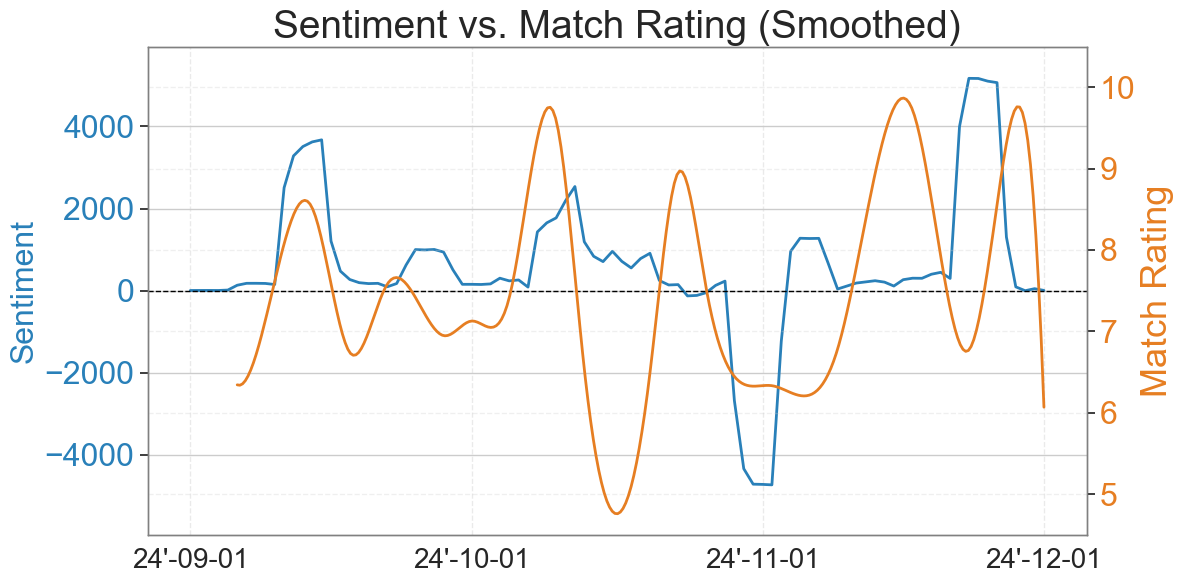

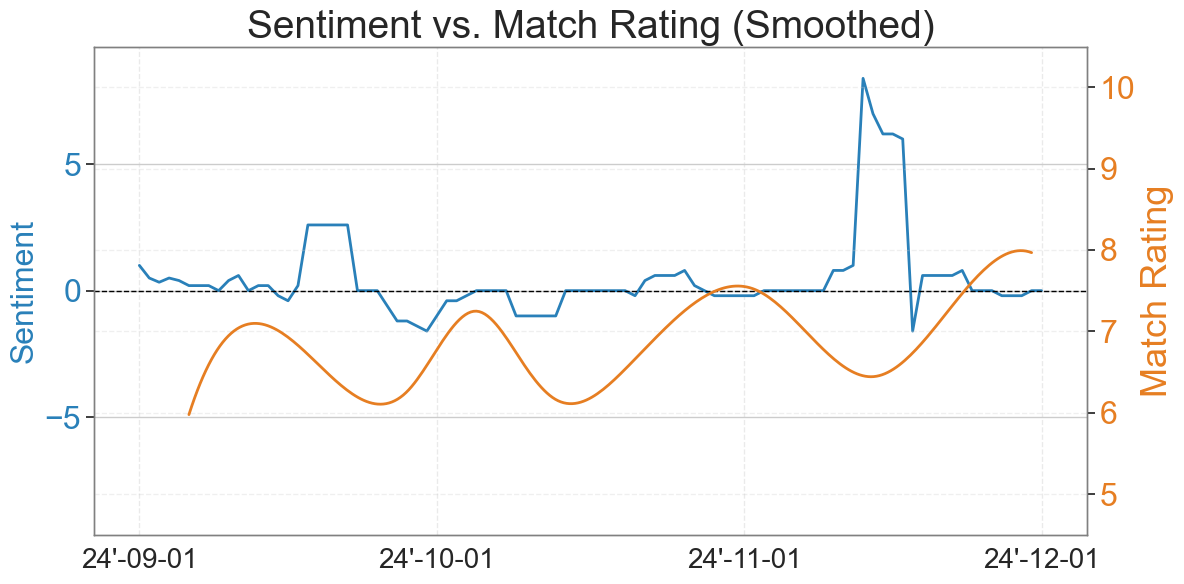

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import matplotlib.dates as mdates

# Define a custom date format
date_format = mdates.DateFormatter("%y'-%m-%d")

# Load daily data
daily_df = pd.read_csv("./dataframes/final_versions/daily_player_dataset.csv", sep="\t", parse_dates=["date"])

# Define players to plot
players = ["Erling Haaland", "Jørgen Strand Larsen"]

# Font sizes
title_fontsize = 28
label_fontsize = 26
tick_fontsize = 23
tick_2 = 20

# Define time window
start_date = "2024-09-01"
end_date = "2024-12-01"

# Plot each player
for player_name in players:
    player_df = daily_df[daily_df["player"] == player_name].copy()
    player_df = player_df.sort_values("date")
    player_df = player_df[(player_df["date"] >= start_date) & (player_df["date"] <= end_date)]

    player_df["sentiment"] = player_df["pos_mentions"] - player_df["neg_mentions"]
    match_df = player_df[player_df["rating"] > 0].copy()

    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.grid(axis='x', linestyle="--", linewidth=1, alpha=0.4)
    ax1.set_axisbelow(True)

    # Smoothed sentiment
    smoothed_sentiment = player_df["sentiment"].rolling(window=5, min_periods=1).mean()
    max_abs_y = max(abs(smoothed_sentiment.min()), abs(smoothed_sentiment.max())) * 1.15
    ax1.set_ylim(-max_abs_y, max_abs_y)

    ax1.plot(player_df["date"], smoothed_sentiment, label="Sentiment", color="#2980B9", linewidth=2)
    ax1.axhline(0, color="black", linestyle="--", linewidth=1)
    ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    ax1.xaxis.set_major_formatter(date_format)

    ax1.set_ylabel("Sentiment", color="#2980B9", fontsize=tick_fontsize)
    ax1.tick_params(axis='x', labelsize=tick_2)
    ax1.tick_params(axis='y', labelcolor="#2980B9", labelsize=tick_fontsize)

    # Remove borders from ax1
    for spine in ax1.spines.values():
        spine.set_color('gray')
        spine.set_linewidth(1)

    # Smoothed rating with spline
    if len(match_df) >= 4:
        x = (match_df["date"] - match_df["date"].min()).dt.days
        y = match_df["rating"]
        spline = UnivariateSpline(x, y, k=3, s=1)

        x_smooth = np.linspace(x.min(), x.max(), 300)
        dates_smooth = match_df["date"].min() + pd.to_timedelta(x_smooth, unit='D')
        y_smooth = spline(x_smooth)

        ax2 = ax1.twinx()
        ax2.plot(dates_smooth, y_smooth, label="Smoothed Rating", color="#E67E22", linewidth=2)
        ax2.set_ylim(4.5, 10.5)
        ax2.set_ylabel("Match Rating", color="#E67E22", fontsize=label_fontsize)
        ax2.tick_params(axis='y', labelcolor="#E67E22", labelsize=tick_fontsize)

        # Remove borders from ax2
        for spine in ax2.spines.values():
            spine.set_color('gray')
            spine.set_linewidth(1)

    plt.title(f"Sentiment vs. Match Rating (Smoothed)", fontsize=title_fontsize)
    fig.tight_layout()
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.show()


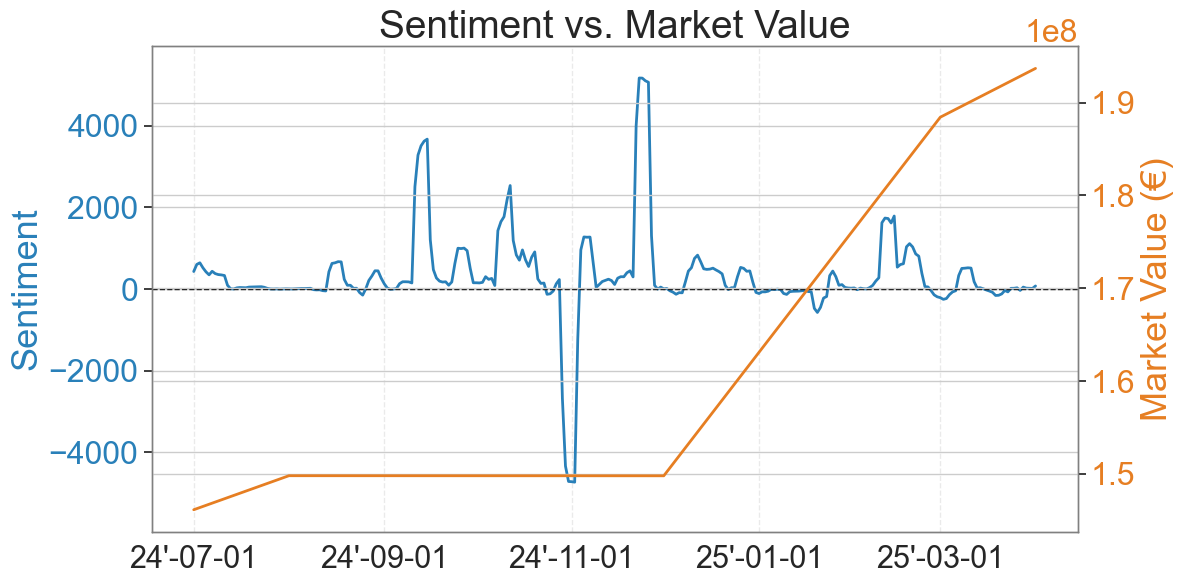

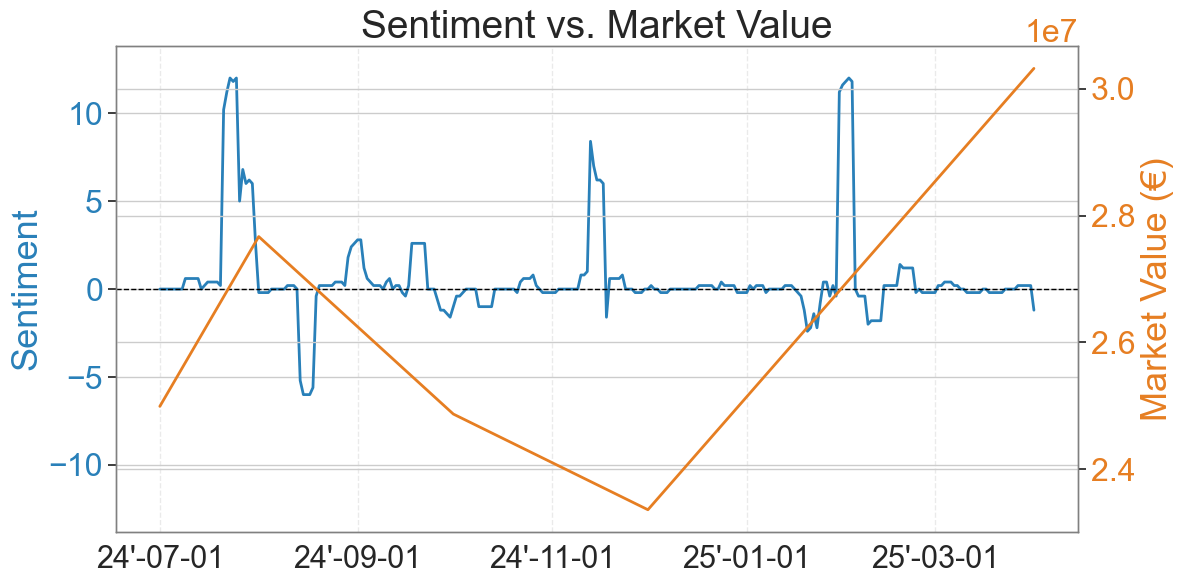

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Define custom date format
date_format = mdates.DateFormatter("%y'-%m-%d")

# Load daily data
daily_df = pd.read_csv("./dataframes/final_versions/daily_player_dataset.csv", sep="\t", parse_dates=["date"])

# Define players to plot
players = ["Erling Haaland", "Jørgen Strand Larsen"]

# Font sizes
title_fontsize = 28
label_fontsize = 26
tick_fontsize = 23
tick_2 = 22

# Define time window
start_date = "2024-07-01"
end_date = "2025-04-01"

# Loop through players
for player_name in players:
    player_df = daily_df[daily_df["player"] == player_name].copy()
    player_df = player_df.sort_values("date")
    player_df = player_df[(player_df["date"] >= start_date) & (player_df["date"] <= end_date)]

    player_df["sentiment"] = player_df["pos_mentions"] - player_df["neg_mentions"]
    smoothed_sentiment = player_df["sentiment"].rolling(window=5, min_periods=1).mean()

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Grid & visual style
    ax1.grid(axis='x', linestyle="--", linewidth=1, alpha=0.4)
    ax1.set_axisbelow(True)

    # Sentiment axis
    ax1.plot(player_df["date"], smoothed_sentiment, label="Sentiment", color="#2980B9", linewidth=2)
    ax1.axhline(0, color="black", linestyle="--", linewidth=1)
    ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1, 13, 2), bymonthday=1))

    ax1.xaxis.set_major_formatter(date_format)

    max_abs_y = max(abs(smoothed_sentiment.min()), abs(smoothed_sentiment.max())) * 1.15
    ax1.set_ylim(-max_abs_y, max_abs_y)

    ax1.set_ylabel("Sentiment", color="#2980B9", fontsize=label_fontsize)
    ax1.tick_params(axis='x', labelsize=tick_2)
    ax1.tick_params(axis='y', labelcolor="#2980B9", labelsize=tick_fontsize)

    

    for spine in ax1.spines.values():
        spine.set_color('gray')
        spine.set_linewidth(1)

    # Market value on secondary axis
    ax2 = ax1.twinx()
    ax2.plot(player_df["date"], player_df["market_value"], label="Market Value", color="#E67E22", linewidth=2)
    ax2.set_ylabel("Market Value (€)", color="#E67E22", fontsize=label_fontsize)
    ax2.tick_params(axis='y', labelcolor="#E67E22", labelsize=tick_fontsize)
    ax2.yaxis.get_offset_text().set_fontsize(tick_fontsize)


    for spine in ax2.spines.values():
        spine.set_color('gray')
        spine.set_linewidth(1)

    plt.title(f"Sentiment vs. Market Value", fontsize=title_fontsize)
    fig.tight_layout()
    plt.show()


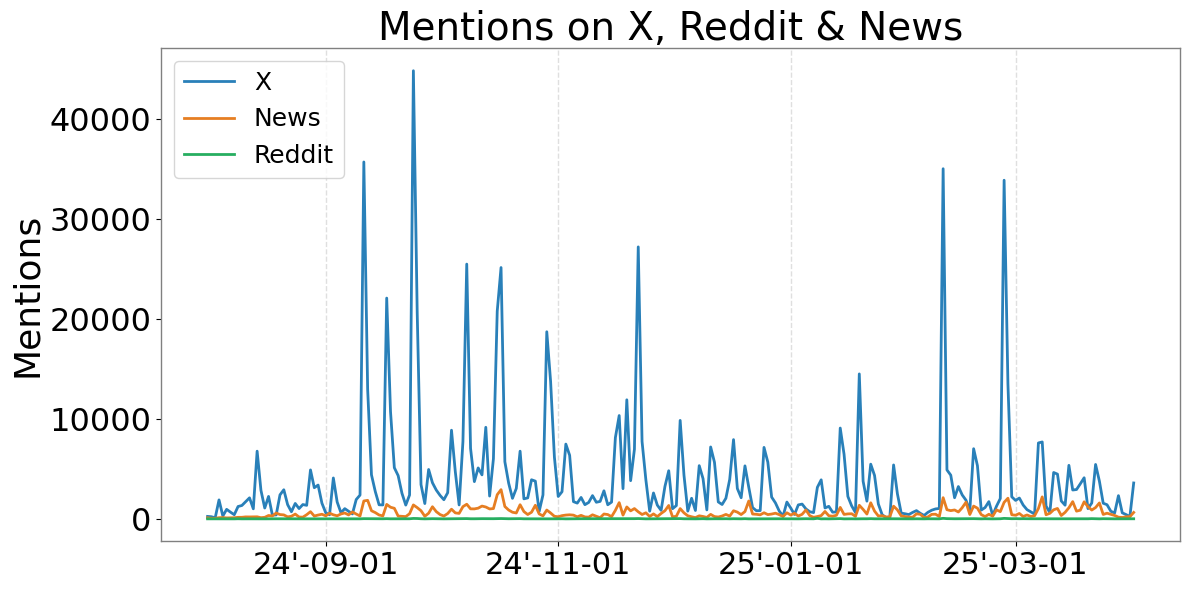

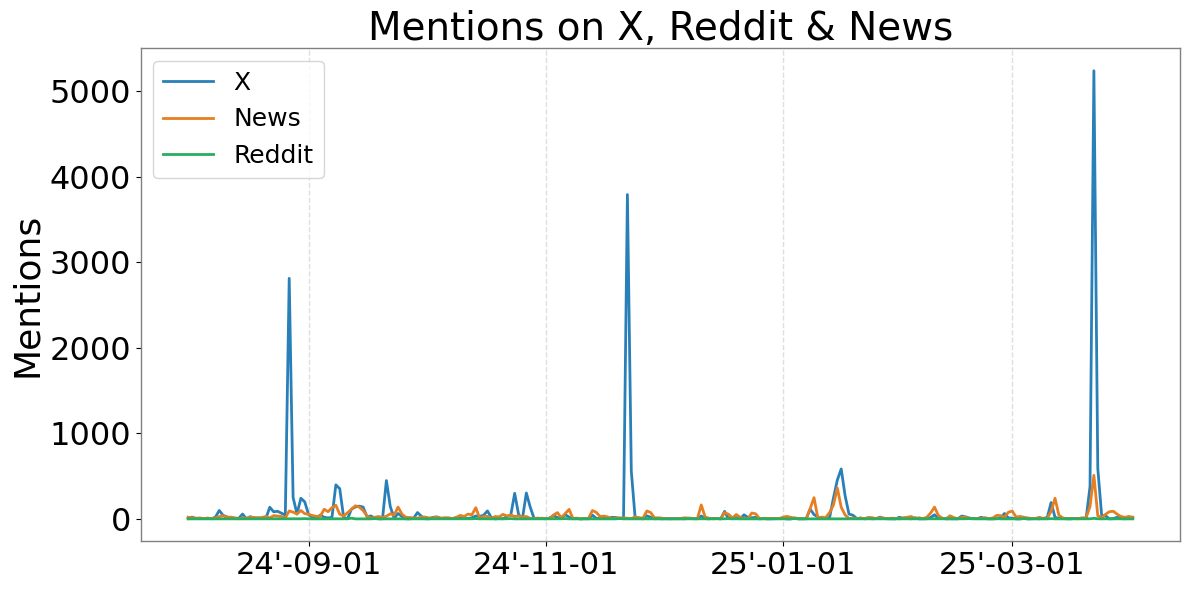

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load daily data
daily_df = pd.read_csv("./dataframes/final_versions/daily_player_dataset.csv", sep="\t", parse_dates=["date"])

# Players to plot
players = ["Erling Haaland", "Alexander Sørloth"]  # Adjust name to match your dataset exactly

# Font sizes
title_fontsize = 28
label_fontsize = 26
tick_fontsize = 23
tick_2 = 22

# Date formatting
date_format = mdates.DateFormatter("%y'-%m-%d")
start_date = "2024-08-01"
end_date = "2025-04-01"

# Loop through players
for player_name in players:
    player_df = daily_df[daily_df["player"] == player_name].copy()
    player_df = player_df.sort_values("date")
    player_df = player_df[(player_df["date"] >= start_date) & (player_df["date"] <= end_date)]

    fig, ax = plt.subplots(figsize=(12, 6))

    # Grid and axis style
    ax.grid(axis='x', linestyle="--", linewidth=1, alpha=0.4)
    ax.set_axisbelow(True)

    # Plot mentions by platform
    ax.plot(player_df["date"], player_df["total_X"], label="X", color="#2980B9", linewidth=2)
    ax.plot(player_df["date"], player_df["total_news"], label="News", color="#E67E22", linewidth=2)
    ax.plot(player_df["date"], player_df["total_reddit"], label="Reddit", color="#27AE60", linewidth=2)

    ax.set_ylabel("Mentions", fontsize=label_fontsize)
    ax.tick_params(axis='x', labelsize=tick_2)
    ax.tick_params(axis='y', labelsize=tick_fontsize)

    # Format x-axis
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1, 13, 2), bymonthday=1))
    ax.xaxis.set_major_formatter(date_format)

    # Borders
    for spine in ax.spines.values():
        spine.set_color('gray')
        spine.set_linewidth(1)

    plt.title(f"Mentions on X, Reddit & News", fontsize=title_fontsize)
    plt.legend(fontsize=18, loc='upper left')
    fig.tight_layout()
    plt.show()


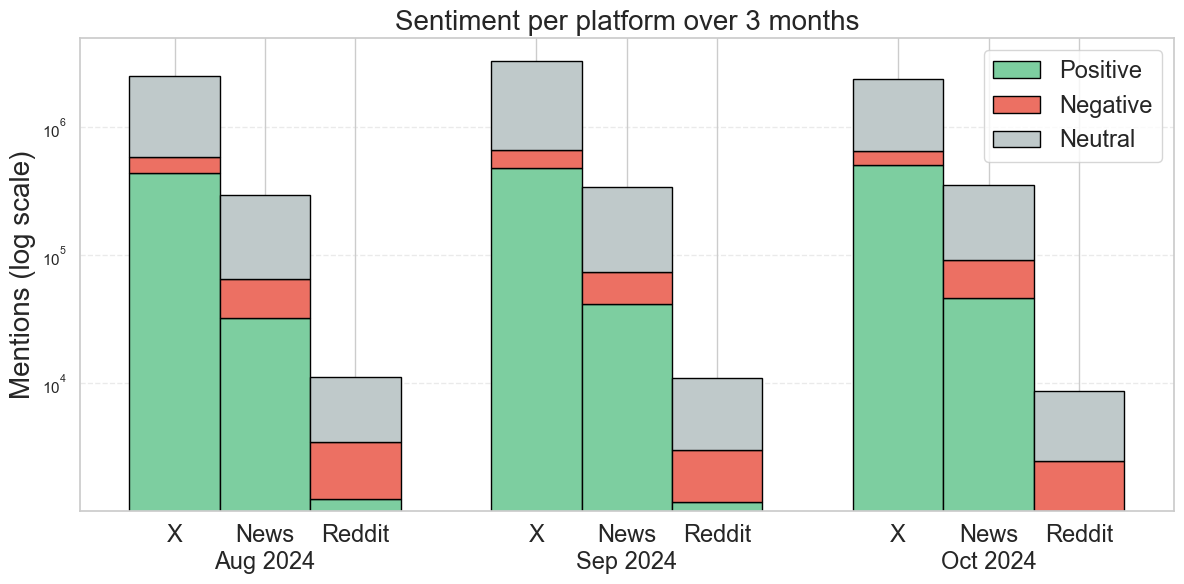

In [102]:
import pandas as pd
import matplotlib.pyplot as plt

# Load monthly dataset
monthly_df = pd.read_csv("./dataframes/final_versions/monthly_encoded.csv", sep="\t", parse_dates=["month"])

# Choose and sort months to compare
months_to_plot = ["2024-08-01", "2024-09-01", "2024-10-01"]
months_dt = [pd.to_datetime(m) for m in months_to_plot]
month_labels = [m.strftime("%b %Y") for m in months_dt]

# Build data for plotting
records = []
for month_dt, label in zip(months_dt, month_labels):
    month_df = monthly_df[monthly_df["month"] == month_dt]
    for platform, short in zip(["X", "news", "reddit"], ["X", "News", "Reddit"]):
        pos = month_df[f"pos_{platform}"].sum()
        neg = month_df[f"neg_{platform}"].sum()
        total = month_df[f"total_{platform}"].sum()
        neutral = total - pos - neg
        records.append({
            "Month": label,
            "Platform": short,
            "Positive": pos,
            "Negative": neg,
            "Neutral": neutral
        })

# Build DataFrame and pivot
df = pd.DataFrame(records)
platforms = ["X", "News", "Reddit"]
sentiments = ["Positive", "Negative", "Neutral"]
colors = {
    "Positive": "#7DCEA0",  # medium soft green
    "Negative": "#EC7063",  # medium soft red
    "Neutral":  "#BFC9CA"   # medium soft gray
}

# Plot setup
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.25
n_platforms = len(platforms)
n_months = len(month_labels)
x = list(range(n_months))

# Draw bars
for i, plat in enumerate(platforms):
    bottom = [0] * n_months
    for sentiment in sentiments:
        values = []
        for m in month_labels:
            val = df[(df["Month"] == m) & (df["Platform"] == plat)][sentiment].values[0]
            values.append(val)
        x_positions = [xi + i * bar_width for xi in x]
        ax.bar(
            x_positions,
            values,
            width=bar_width,
            bottom=bottom,
            color=colors[sentiment],
            edgecolor="black",
            label=sentiment if i == 0 else None
        )
        bottom = [b + v for b, v in zip(bottom, values)]

# Fix x-axis ticks and labels
xtick_positions = []
xtick_labels = []

for i, m in enumerate(month_labels):
    for j, p in enumerate(platforms):
        xpos = i + j * bar_width
        xtick_positions.append(xpos)
        if p == "News":  # only center bar gets the month label
            xtick_labels.append(f"{p}\n{m}")
        else:
            xtick_labels.append(p)

ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, fontsize=17)


# Labels, legend, formatting
ax.set_title("Sentiment per platform over 3 months", fontsize=20)
ax.set_ylabel("Mentions (log scale)", fontsize=20)
ax.set_yscale("log")
ax.grid(axis='y', linestyle="--", alpha=0.4)
ax.legend(fontsize=17)
fig.tight_layout()
plt.show()
